In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights

# utils specific to quantization
from utils import train, quantize
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_densenet import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

# load pretrained model, accuracy ~85%
model.load_state_dict(torch.load('../densenet/model121.pytorch_state'))

#### Keep copy of full precision kernels

In [9]:
# copy all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[2]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

#### initial quantization 

In [10]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[2]['params']]

In [11]:
for k, k_fp in zip(all_kernels, all_fp_kernels):
    
    k.data = quantize(k_fp.data)

#### parameter updaters

In [12]:
# optimizer for updating only all_fp_kernels
optimizer_fp = optim.SGD(all_fp_kernels, lr=1e-3, momentum=0.9, nesterov=True)

# Train

In [13]:
n_epochs = 15
n_batches = ceil(train_size/batch_size)
n_batches

531

In [14]:
%%time
all_losses, _ = train(
    model, criterion, 
    optimizer, optimizer_fp,
    train_iterator, n_epochs, n_batches,
    val_iterator, validation_step=531, n_validation_batches=80
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  5.369 4.697  0.033 0.084  0.119 0.227  218.751
2.00  4.743 4.243  0.089 0.142  0.246 0.326  207.884
3.00  4.373 3.923  0.138 0.190  0.331 0.409  207.509
4.00  4.065 3.719  0.180 0.216  0.390 0.451  208.273
5.00  3.856 3.538  0.213 0.252  0.434 0.487  207.493
6.00  3.663 3.392  0.240 0.273  0.473 0.526  207.671
7.00  3.530 3.252  0.262 0.305  0.503 0.550  207.735
8.00  3.375 3.140  0.279 0.323  0.528 0.574  207.907
9.00  3.239 3.035  0.308 0.340  0.556 0.597  208.028
10.00  3.138 2.935  0.323 0.353  0.582 0.611  207.854
11.00  3.027 2.868  0.342 0.376  0.599 0.625  208.290
12.00  2.961 2.788  0.355 0.382  0.610 0.639  207.880
13.00  2.866 2.729  0.370 0.397  0.629 0.656  208.045
14.00  2.788 2.697  0.378 0.399  0.642 0.656  207.718
15.00  2.720 2.659  0.391 0.410  0.654 0.667  207.593
CPU times: user 42min 52s, sys: 8min 59s, total: 51min 52s
Wall time: 52min 8s


# Loss/epoch plots

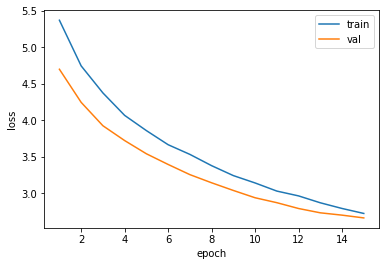

In [15]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

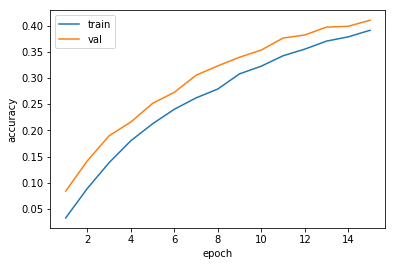

In [16]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

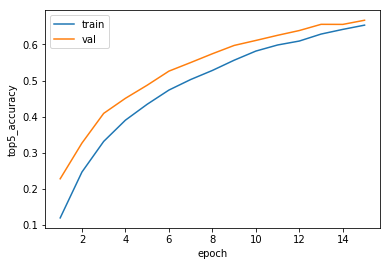

In [17]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [18]:
model.cpu();
torch.save(model.state_dict(), 'model_binary_quantization.pytorch_state')